<a href="https://colab.research.google.com/github/akrity8521/Medicare-Fraud-Detection/blob/main/Copy_of_Thesis_Implementation_catboost_partD(with_autoencoders_and_with_SMOTE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing catboost library

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 154 kB/s 


#Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import scipy
import os 
import matplotlib.pyplot as plt
import random
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from scipy.stats import ttest_ind

from sklearn import metrics
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import TSNE
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from sklearn.manifold import TSNE
from keras import regularizers

import catboost as cb
import xgboost as xgb
from sklearn import ensemble 
import lightgbm as lgb

#Read Part D Dataset

In [ ]:
#connnecting drive with google colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/PartD_Prescriber_PUF_NPI_Drug_18.txt',sep="\t",nrows=1500000)

In [ ]:
dataset.shape  # only 1.5M rows are read due to less RAM 

(1500000, 21)

In [ ]:
dataset.columns

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_city', 'nppes_provider_state', 'specialty_description',
       'description_flag', 'drug_name', 'generic_name', 'bene_count',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'bene_count_ge65', 'bene_count_ge65_suppress_flag',
       'total_claim_count_ge65', 'ge65_suppress_flag',
       'total_30_day_fill_count_ge65', 'total_day_supply_ge65',
       'total_drug_cost_ge65'],
      dtype='object')

#Feature Selection

In [ ]:
dataset= dataset.loc[:,['npi', 'specialty_description','nppes_provider_state', 'description_flag',\
                        'drug_name','bene_count','total_claim_count','total_30_day_fill_count','total_day_supply','total_drug_cost']]

In [ ]:
dataset = dataset.drop_duplicates()

In [ ]:
dataset=dataset.dropna()

In [ ]:
dataset.shape

(614806, 10)

In [ ]:
dataset.columns

Index(['npi', 'specialty_description', 'nppes_provider_state',
       'description_flag', 'drug_name', 'bene_count', 'total_claim_count',
       'total_30_day_fill_count', 'total_day_supply', 'total_drug_cost'],
      dtype='object')

In [ ]:
dataset.head()

,npi,specialty_description,nppes_provider_state,description_flag,drug_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
1,1003000126,Internal Medicine,MD,S,AZITHROMYCIN,11.0,11,11.0,64,123.11
3,1003000126,Internal Medicine,MD,S,CEFDINIR,12.0,12,12.0,71,178.66
4,1003000126,Internal Medicine,MD,S,DOXYCYCLINE HYCLATE,12.0,13,13.0,77,194.56
6,1003000126,Internal Medicine,MD,S,FUROSEMIDE,19.0,30,31.0,830,118.97
7,1003000126,Internal Medicine,MD,S,ISOSORBIDE MONONITRATE ER,11.0,14,14.0,420,167.69


In [ ]:
n = len(pd.unique(dataset['drug_name']))
print("No.of.unique values :", n)

n = len(pd.unique(dataset['specialty_description']))
print("No.of.unique values :", n)

n = len(pd.unique(dataset['description_flag']))
print("No.of.unique values :", n)

n = len(pd.unique(dataset['nppes_provider_state']))
print("No.of.unique values :", n)

No.of.unique values : 1193
No.of.unique values : 102
No.of.unique values : 2
No.of.unique values : 59


In [ ]:
dataset.dtypes

npi                          int64
specialty_description       object
nppes_provider_state        object
description_flag            object
drug_name                   object
bene_count                 float64
total_claim_count            int64
total_30_day_fill_count    float64
total_day_supply             int64
total_drug_cost            float64
dtype: object

#One Hot Encoding the categorical Variables

In [ ]:
rated_dummies1 = pd.get_dummies(dataset.nppes_provider_state)
dataset=pd.concat([dataset, rated_dummies1], axis=1)
rated_dummies2 = pd.get_dummies(dataset.specialty_description)
dataset=pd.concat([dataset, rated_dummies2], axis=1)
rated_dummies3 = pd.get_dummies(dataset.drug_name)
dataset=pd.concat([dataset, rated_dummies3], axis=1)
rated_dummies4 = pd.get_dummies(dataset.description_flag)
dataset=pd.concat([dataset, rated_dummies4], axis=1)
dataset = dataset.drop(['nppes_provider_state','specialty_description','drug_name','description_flag'], axis=1)

In [ ]:
dataset.shape

(614806, 1362)

In [ ]:
# label encoding
# dataset['nppes_provider_state'] = pd.Categorical(dataset['nppes_provider_state']).codes
# dataset['specialty_description'] = pd.Categorical(dataset['specialty_description']).codes
# dataset['drug_name'] = pd.Categorical(dataset['drug_name']).codes

In [ ]:
dataset.dtypes

npi                          int64
bene_count                 float64
total_claim_count            int64
total_30_day_fill_count    float64
total_day_supply             int64
                            ...   
ZYLET                        uint8
ZYPREXA RELPREVV             uint8
ZYTIGA                       uint8
S                            uint8
T                            uint8
Length: 1362, dtype: object

#Read LEIE Dataset

In [ ]:
IELErawdata = "/content/drive/My Drive/LEIE.csv"
IELE_pd = pd.read_csv(IELErawdata)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#Feature Selection

In [ ]:
npifraud_pd0 = IELE_pd.loc[:,['NPI','EXCLTYPE']]

In [ ]:
npifraud_pd1 = npifraud_pd0.query('NPI !=0')

In [ ]:
rename_dict = {'NPI':'npi', 'EXCLTYPE':'is_fraud'}
npi_fraud_pd = npifraud_pd1.rename(columns=rename_dict)

In [ ]:
npi_fraud_pd['is_fraud'] = 1

#Left Joined LEIE and Part D dataset on NPI 

In [ ]:
# Features Engineering 
Features_pd1 = pd.merge(dataset,npi_fraud_pd, how ='left',on = 'npi')

In [ ]:
Features_pd1.fillna(0, inplace=True)

In [ ]:
Features_pd1['is_fraud'].value_counts()

0.0    614465
1.0       341
Name: is_fraud, dtype: int64

In [ ]:
Non_fraud, Fraud = Features_pd1['is_fraud'].value_counts()
Non_fraud_perc = Non_fraud*100 / (Fraud+Non_fraud)
Fraud_perc = Fraud*100 / (Fraud+Non_fraud)
print("Fraud Percentage", Fraud_perc)
print("Non_fraud Percentage", Non_fraud_perc)

Fraud Percentage 0.05546465063776215
Non_fraud Percentage 99.94453534936224


In [ ]:
Features_pd1[Features_pd1['is_fraud']==1].count()

npi                        341
bene_count                 341
total_claim_count          341
total_30_day_fill_count    341
total_day_supply           341
                          ... 
ZYPREXA RELPREVV           341
ZYTIGA                     341
S                          341
T                          341
is_fraud                   341
Length: 1363, dtype: int64

In [ ]:
FeaturesAll_pd=Features_pd1

In [ ]:
FeaturesAll_pd.nunique()

npi                        46706
bene_count                   570
total_claim_count           1709
total_30_day_fill_count    13742
total_day_supply           31199
                           ...  
ZYPREXA RELPREVV               2
ZYTIGA                         2
S                              2
T                              2
is_fraud                       2
Length: 1363, dtype: int64

#Dropped the NPI Column as it is used only for table joining

In [ ]:
FeaturesAll_pd = FeaturesAll_pd.drop(['npi'], axis=1)


In [ ]:
FeaturesAll_pd

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,AA,AE,AK,AL,AR,...,ZONISAMIDE,ZONTIVITY,ZOSTAVAX,ZUBSOLV,ZYLET,ZYPREXA RELPREVV,ZYTIGA,S,T,is_fraud
0,11.0,11,11.0,64,123.11,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
1,12.0,12,12.0,71,178.66,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
2,12.0,13,13.0,77,194.56,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
3,19.0,30,31.0,830,118.97,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
4,11.0,14,14.0,420,167.69,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614801,11.0,13,13.0,342,168.69,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
614802,20.0,29,29.0,795,1983.36,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
614803,48.0,80,80.0,1668,461.67,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
614804,19.0,52,54.0,1620,727.96,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0


#Data Preprocessing

In [ ]:
x = FeaturesAll_pd.drop(columns=['is_fraud'], axis=1)
y = FeaturesAll_pd['is_fraud']

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [ ]:
x

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,AA,AE,AK,AL,AR,...,ZOLPIDEM TARTRATE ER,ZONISAMIDE,ZONTIVITY,ZOSTAVAX,ZUBSOLV,ZYLET,ZYPREXA RELPREVV,ZYTIGA,S,T
0,11.0,11,11.0,64,123.11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,12.0,12,12.0,71,178.66,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,12.0,13,13.0,77,194.56,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,19.0,30,31.0,830,118.97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,11.0,14,14.0,420,167.69,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614801,11.0,13,13.0,342,168.69,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
614802,20.0,29,29.0,795,1983.36,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
614803,48.0,80,80.0,1668,461.67,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
614804,19.0,52,54.0,1620,727.96,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Autoencoder

In [ ]:
## input layer 
input_layer = Input(shape=(x.shape[1],))

## encoding part
encoded = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## code part
##code = Dense(20, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(x.shape[1], activation='relu')(decoded)


In [ ]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

In [ ]:
print(x_norm.shape[0])

614465


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, restore_best_weights=True)
history=autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 128, epochs = 50, callbacks=[es],
                shuffle = True, validation_split =0.20);

Epoch 1/50
13/13 [==============================] - 3s 17ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 8/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 10/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 11/50
13/13 

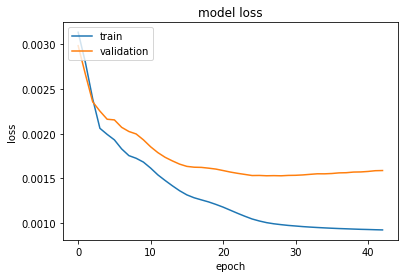

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
hid_rep = Sequential()
hid_rep .add(autoencoder.layers[0])
hid_rep .add(autoencoder.layers[1])
hid_rep .add(autoencoder.layers[2])

In [ ]:
x_norm.shape

(614465, 1361)

In [ ]:
non_fraud = FeaturesAll_pd[FeaturesAll_pd['is_fraud'] == 0].sample(1000)
fraud = FeaturesAll_pd[FeaturesAll_pd['is_fraud'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
df.head()

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,AA,AE,AK,AL,AR,...,ZONISAMIDE,ZONTIVITY,ZOSTAVAX,ZUBSOLV,ZYLET,ZYPREXA RELPREVV,ZYTIGA,S,T,is_fraud
0,52.0,85,176.2,5278,1478.47,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
1,15.0,80,90.0,2674,1014.07,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
2,12.0,45,77.0,2310,31658.27,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
3,19.0,83,83.0,755,1088.19,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
4,30.0,30,30.0,152,3310.14,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0.0


In [ ]:
X = df.drop(['is_fraud'], axis = 1).values
Y = df["is_fraud"].values

#TSNE Representation

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=24)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    


#tsne on original data

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


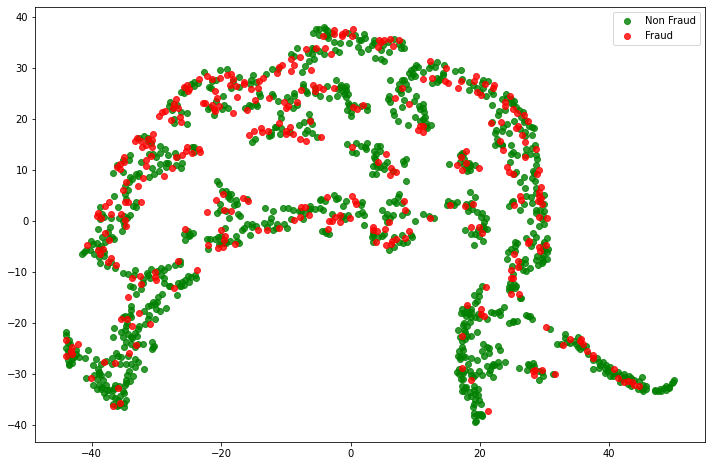

In [ ]:
tsne_plot(X, Y, "original.png")

#Taken the hidden represenation from encoder

In [ ]:
norm_hid_rep = hid_rep .predict(x_norm[:2000])
fraud_hid_rep = hid_rep .predict(x_fraud)
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

#tsne on encoded data

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


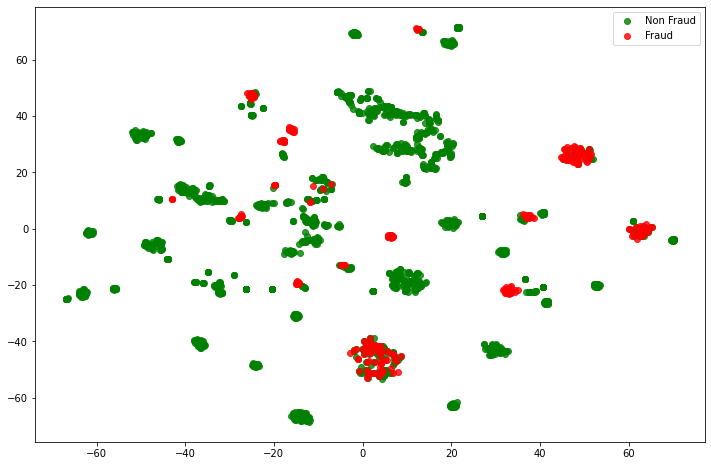

In [ ]:
tsne_plot(rep_x, rep_y, "latent_representation.png")

# Train Test Split

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=123, stratify=rep_y)

#SMOTE implementation

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=123)
train_x, train_y = sm.fit_resample(rep_x, rep_y)

#CatBoost Classifier

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.018621
0:	learn: 0.6762476	total: 54.3ms	remaining: 54.2s
1:	learn: 0.6584767	total: 60.8ms	remaining: 30.4s
2:	learn: 0.6436121	total: 67.1ms	remaining: 22.3s
3:	learn: 0.6291986	total: 73.2ms	remaining: 18.2s
4:	learn: 0.6146957	total: 79.6ms	remaining: 15.8s
5:	learn: 0.6003774	total: 85.9ms	remaining: 14.2s
6:	learn: 0.5871027	total: 92ms	remaining: 13s
7:	learn: 0.5747724	total: 98.2ms	remaining: 12.2s
8:	learn: 0.5631573	total: 105ms	remaining: 11.5s
9:	learn: 0.5534844	total: 112ms	remaining: 11.1s
10:	learn: 0.5419185	total: 118ms	remaining: 10.6s
11:	learn: 0.5323887	total: 125ms	remaining: 10.3s
12:	learn: 0.5229694	total: 131ms	remaining: 9.94s
13:	learn: 0.5106613	total: 138ms	remaining: 9.7s
14:	learn: 0.5010856	total: 144ms	remaining: 9.47s
15:	learn: 0.4930289	total: 151ms	remaining: 9.27s
16:	learn: 0.4812376	total: 157ms	remaining: 9.07s
17:	learn: 0.4736460	total: 163ms	remaining: 8.91s
18:	learn: 0.4621499	total: 170ms	remaining: 8.78s
19:	lear

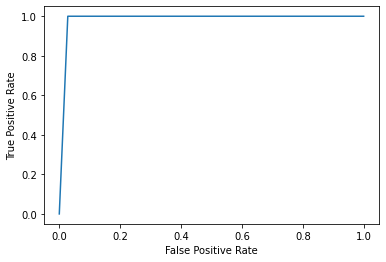

In [ ]:
clf = cb.CatBoostClassifier()
clf.fit(train_x, train_y,plot=True)
pred_y = clf.predict(val_x)

print ("")
print ("confusion_matrixt: ")
print (confusion_matrix(val_y, pred_y))

print ("")
print (classification_report(val_y, pred_y))
print ("Precision: ", precision_score(val_y, pred_y))
print ("Recall: ", recall_score(val_y, pred_y))
print ("F1 Score: ", f1_score(val_y, pred_y))
print ("Auc Score: ", roc_auc_score(val_y, pred_y))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

fpr, tpr, _ = metrics.roc_curve(val_y,  pred_y)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#AdaBoost Classifier


confusion_matrixt: 
[[446  55]
 [  1  84]]

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94       501
         1.0       0.60      0.99      0.75        85

    accuracy                           0.90       586
   macro avg       0.80      0.94      0.85       586
weighted avg       0.94      0.90      0.91       586

Precision:  0.60431654676259
Recall:  0.9882352941176471
F1 Score:  0.75
Auc Score:  0.9392274274979453
Accuracy Score:  0.9044368600682594


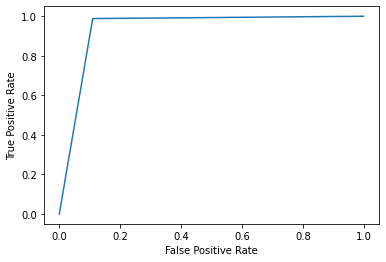

In [ ]:
clf = ensemble.AdaBoostClassifier()
clf.fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("confusion_matrixt: ")
print (confusion_matrix(val_y, pred_y))

print ("")
print (classification_report(val_y, pred_y))
print ("Precision: ", precision_score(val_y, pred_y))
print ("Recall: ", recall_score(val_y, pred_y))
print ("F1 Score: ", f1_score(val_y, pred_y))
print ("Auc Score: ", roc_auc_score(val_y, pred_y))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

fpr, tpr, _ = metrics.roc_curve(val_y,  pred_y)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#XGBoost Classifier


confusion_matrixt: 
[[454  47]
 [  0  85]]

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95       501
         1.0       0.64      1.00      0.78        85

    accuracy                           0.92       586
   macro avg       0.82      0.95      0.87       586
weighted avg       0.95      0.92      0.93       586

Precision:  0.6439393939393939
Recall:  1.0
F1 Score:  0.7834101382488479
Auc Score:  0.9530938123752495
Accuracy Score:  0.9197952218430034


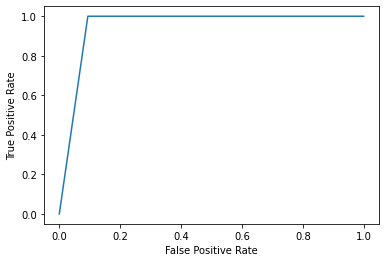

In [ ]:
clf =  xgb.XGBClassifier()
clf.fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("confusion_matrixt: ")
print (confusion_matrix(val_y, pred_y))

print ("")
print (classification_report(val_y, pred_y))
print ("Precision: ", precision_score(val_y, pred_y))
print ("Recall: ", recall_score(val_y, pred_y))
print ("F1 Score: ", f1_score(val_y, pred_y))
print ("Auc Score: ", roc_auc_score(val_y, pred_y))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

fpr, tpr, _ = metrics.roc_curve(val_y,  pred_y)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#LightGBM Classifier


confusion_matrixt: 
[[496   5]
 [  0  85]]

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       501
         1.0       0.94      1.00      0.97        85

    accuracy                           0.99       586
   macro avg       0.97      1.00      0.98       586
weighted avg       0.99      0.99      0.99       586

Precision:  0.9444444444444444
Recall:  1.0
F1 Score:  0.9714285714285714
Auc Score:  0.9950099800399201
Accuracy Score:  0.9914675767918089


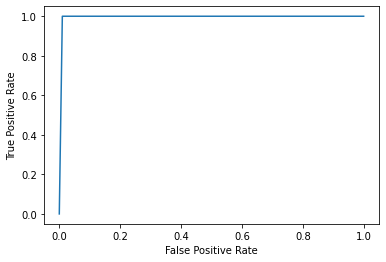

In [ ]:
clf =  lgb.LGBMClassifier()
clf.fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("confusion_matrixt: ")
print (confusion_matrix(val_y, pred_y))

print ("")
print (classification_report(val_y, pred_y))
print ("Precision: ", precision_score(val_y, pred_y))
print ("Recall: ", recall_score(val_y, pred_y))
print ("F1 Score: ", f1_score(val_y, pred_y))
print ("Auc Score: ", roc_auc_score(val_y, pred_y))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

fpr, tpr, _ = metrics.roc_curve(val_y, pred_y)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()